In [22]:
# import library
import numpy as np
import pandas as pd
import xgboost as xgb
import gc
import warnings
warnings.filterwarnings('ignore')

In [23]:
# Read the data
train = pd.read_csv('./data/train_2016_v2.csv')
prop = pd.read_csv('./data/properties_2016.csv')
sample = pd.read_csv('./data/sample_submission.csv')

In [24]:
# Data Preprocessing
for c, dtype in zip(prop.columns, prop.dtypes):
    if dtype == np.float64:
        prop[c] = prop[c].astype(np.float32)

df_train = train.merge(prop, how='left', on='parcelid')

x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)
y_train = df_train['logerror'].values

train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

# Create training and validation dataset
split = 80000
x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

# Build DMatrix
d_train = xgb.DMatrix(x_train, label = y_train)
d_valid = xgb.DMatrix(x_valid, label = y_valid)

In [25]:
# Train Model
params = {}
params['eta'] = 0.02
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 4
params['silent'] = 1

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 10000, watchlist,
                early_stopping_rounds=100, verbose_eval=10)

[0]	train-mae:0.06863	valid-mae:0.06655
[10]	train-mae:0.06858	valid-mae:0.06658
[20]	train-mae:0.06855	valid-mae:0.06659
[30]	train-mae:0.06853	valid-mae:0.06661
[40]	train-mae:0.06852	valid-mae:0.06663
[50]	train-mae:0.06850	valid-mae:0.06664
[60]	train-mae:0.06848	valid-mae:0.06665
[70]	train-mae:0.06847	valid-mae:0.06667
[80]	train-mae:0.06845	valid-mae:0.06669
[90]	train-mae:0.06844	valid-mae:0.06670
[99]	train-mae:0.06842	valid-mae:0.06671


<Axes: >

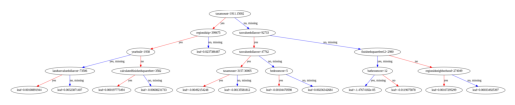

In [26]:
xgb.plot_tree(clf, num_trees=2)

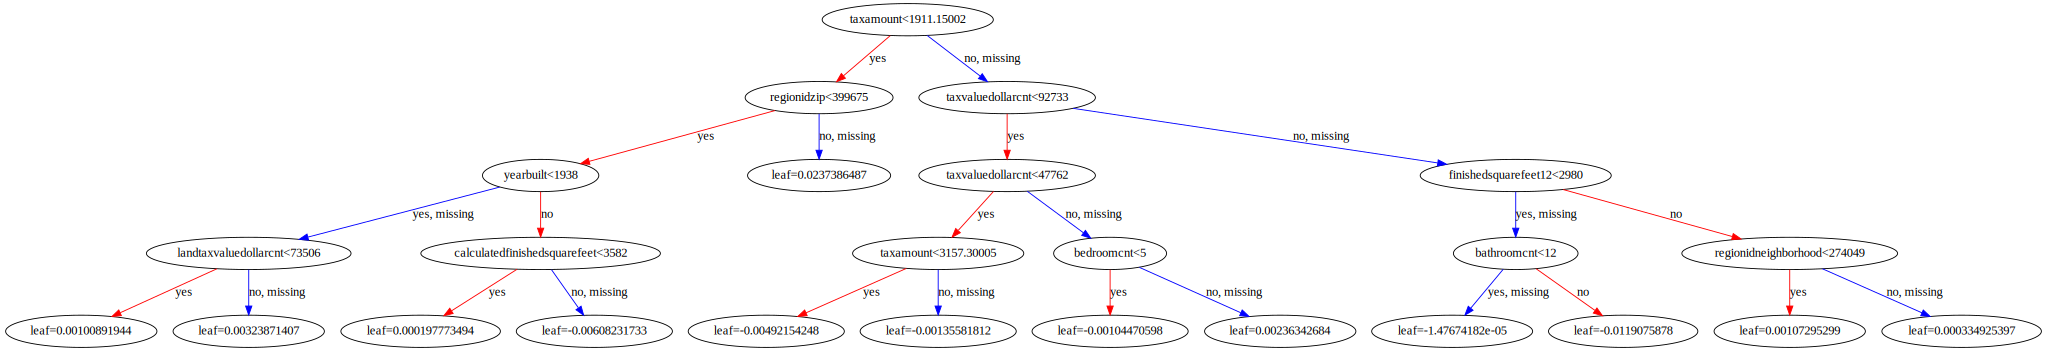

In [27]:
xgb.to_graphviz(clf, num_trees=2)

In [28]:
# Run on test data
sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(prop, on='parcelid', how = 'left')

x_test = df_test[train_columns]
for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)

d_test = xgb.DMatrix(x_test)
p_test = clf.predict(d_test)

In [ ]:
# Create submission file
sub = pd.read_csv('./data/sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = p_test

sub.to_csv('xgb_starter.csv', index=False, float_format='%.4f')